In [27]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Data Loading

In [2]:
train = pd.read_csv("data/cs-training.csv")
print("shape", train.shape)
train.head()

shape (150000, 12)


,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [6]:
train.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

In [8]:
print(np.unique(train['SeriousDlqin2yrs'], return_counts=True))

(array([0, 1]), array([139974,  10026]))


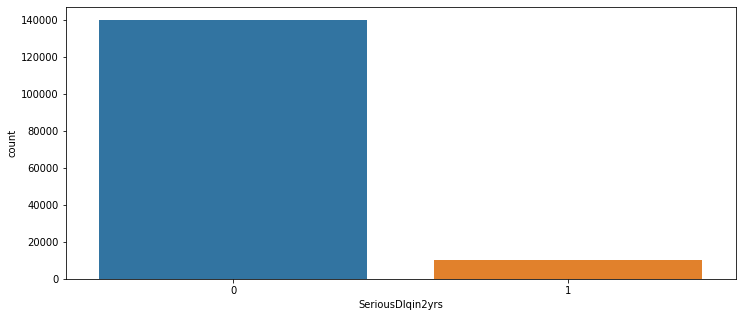

In [13]:
plt.figure(figsize=[12, 5])
sns.countplot(x='SeriousDlqin2yrs', data=train)

## Preliminary
---
So data is unbalanced, let's run a basic model and see how it goes

In [26]:
from sklearn.model_selection import train_test_split
import gc
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, precision_recall_curve
import lightgbm as lgb

### Utility functions for training

In [15]:
def evalulation(y_test, predictions):    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predictions)
    precision, recall, thresholds = precision_recall_curve(y_test, predictions)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    f1_m = f1_score(y_test, predictions.round())
    accuracy_m = accuracy_score(y_test, predictions.round())
    confusion_m = confusion_matrix(y_test, predictions.round())
    
    print(" Precison score {}".format(precision_score(y_test, predictions.round())))
    print(" Recall score {}".format(recall_score(y_test, predictions.round())))
    print(" AUC score %f" % roc_auc)
    print(" F1 score %f" % f1_m)
    print(" Accuracy Score %f" % accuracy_m)

    print(" Confusion Matrix:")
    print(confusion_m)
    print("Evaluation is completed.")

In [16]:
def train_lgb(df_train, feat_X, feat_y, cat_feat, params, 
              plot=True, seed=123, N=1000, file_path='model/lgb.txt', shuffle=True, test_pct=0.3):
    
    # train test split
    non_feat = [c for c in df_train.columns if c != feat_y]
    
    X, y = df_train[non_feat], df_train[feat_y]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_pct, random_state=seed, shuffle=shuffle)
    
    print("training size", X_train.shape)
    print("testing size", X_test.shape)

    lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=False)
    lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train, free_raw_data=False)
    
    N = N
    model = lgb.train(params,
                      lgb_train,
                      num_boost_round=N,
                      valid_sets=lgb_test,
                      categorical_feature=cat_feat,
                      early_stopping_rounds=100)
    
    print("save model to", file_path)
    model.save_model(file_path)
    # validation
    print("evaluating model ...")
    y_pred = model.predict(X_test)
    print("garbage collected \n", gc.collect())
    
    evalulation(y_test, y_pred)
    
    if plot:
        lgb.plot_importance(model)

In [18]:
# split feature and label
feat_y = 'SeriousDlqin2yrs'
feat_X = [c for c in train.columns if c != feat_y]

## Feature Definition
---
- `SeriousDlqin2yrs` Person experienced 90 days past due delinquency or worse Y/N
- `RevolvingUtilizationOfUnsecuredLines` Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits percentage
- `age` Age of borrower in years integer
- `NumberOfTime3059DaysPastDueNotWorse` Number of times borrower has been 30-59 days past due but no worse in the last 2 years. integer
- `DebtRatio` Monthly debt payments, alimony,living costs divided by monthy gross income percentage
- `MonthlyIncome` Monthly income real
- `NumberOfOpenCreditLinesAndLoans` Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards) integer
- `NumberOfTimes90DaysLate` Number of times borrower has been 90 days or more past due. integer
- `NumberRealEstateLoansOrLines` Number of mortgage and real estate loans including home equity lines of credit integer
- `NumberOfTime60-89DaysPastDueNotWorse` Number of times borrower has been 60-89 days past due but no worse in the last 2 years. integer
- `NumberOfDependents` Number of dependents in family excluding themselves (spouse, children etc.) integer

training size (105000, 10)
testing size (45000, 10)
[1]	valid_0's binary_logloss: 0.617117	valid_0's auc: 0.845754
Train until valid scores didn't improve in 100 rounds.
[2]	valid_0's binary_logloss: 0.554939	valid_0's auc: 0.846609
[3]	valid_0's binary_logloss: 0.503249	valid_0's auc: 0.847462
[4]	valid_0's binary_logloss: 0.459788	valid_0's auc: 0.849326
[5]	valid_0's binary_logloss: 0.42291	valid_0's auc: 0.852457
[6]	valid_0's binary_logloss: 0.391385	valid_0's auc: 0.852407
[7]	valid_0's binary_logloss: 0.364266	valid_0's auc: 0.852947
[8]	valid_0's binary_logloss: 0.340842	valid_0's auc: 0.85288
[9]	valid_0's binary_logloss: 0.320554	valid_0's auc: 0.853236
[10]	valid_0's binary_logloss: 0.302888	valid_0's auc: 0.853231
[11]	valid_0's binary_logloss: 0.287529	valid_0's auc: 0.853291
[12]	valid_0's binary_logloss: 0.274096	valid_0's auc: 0.853558
[13]	valid_0's binary_logloss: 0.262371	valid_0's auc: 0.853759
[14]	valid_0's binary_logloss: 0.252098	valid_0's auc: 0.853785
[15]	val

[147]	valid_0's binary_logloss: 0.17748	valid_0's auc: 0.866721
[148]	valid_0's binary_logloss: 0.177477	valid_0's auc: 0.866735
[149]	valid_0's binary_logloss: 0.177489	valid_0's auc: 0.86672
[150]	valid_0's binary_logloss: 0.177515	valid_0's auc: 0.866679
[151]	valid_0's binary_logloss: 0.177519	valid_0's auc: 0.866656
[152]	valid_0's binary_logloss: 0.177525	valid_0's auc: 0.866656
[153]	valid_0's binary_logloss: 0.177544	valid_0's auc: 0.866634
[154]	valid_0's binary_logloss: 0.177546	valid_0's auc: 0.866604
[155]	valid_0's binary_logloss: 0.177518	valid_0's auc: 0.866639
[156]	valid_0's binary_logloss: 0.177519	valid_0's auc: 0.866648
[157]	valid_0's binary_logloss: 0.177517	valid_0's auc: 0.866655
[158]	valid_0's binary_logloss: 0.177521	valid_0's auc: 0.866645
[159]	valid_0's binary_logloss: 0.177515	valid_0's auc: 0.866675
[160]	valid_0's binary_logloss: 0.177518	valid_0's auc: 0.866661
[161]	valid_0's binary_logloss: 0.177521	valid_0's auc: 0.866665
[162]	valid_0's binary_logl

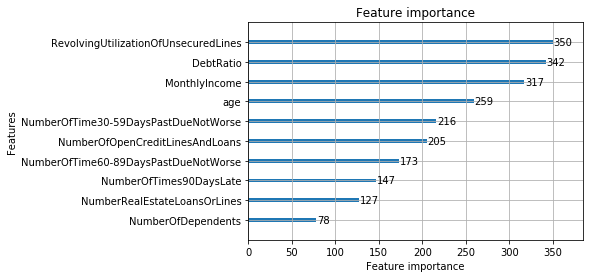

In [22]:
# from the description, looks like no categorical features
params = {'objective': 'binary',
          'metric': ['auc', 'binary_logloss'],
          'learning_rate': 0.1,
          'max_depth': 5,
          'verbose': 0,
          'min_data_in_leaf': 200,
          'num_leaves': 32,
          'boosting_type': 'gbdt',
         }

train_lgb(train, feat_X, feat_y, cat_feat=None, params=params, plot=True, seed=100, N=1000)

## Tweak
---
Basically the `AUC` looks not bad, but since this is a unbalanced data set, let's see if we could apply some extra skills to improve the result

In [24]:
# downsampling the majority
train_major = train[train['SeriousDlqin2yrs'] == 0]
train_minor = train[train['SeriousDlqin2yrs'] == 1]

sample_size = 50000
train_sample_major = train_major.sample(sample_size)

train_resize = pd.concat([train_sample_major, train_minor])

print("Resample size", train_resize.shape)
print("0:1", np.unique(train_resize['SeriousDlqin2yrs'], return_counts=True))

Resample size (60026, 11)
0:1 (array([0, 1]), array([50000, 10026]))


training size (42018, 10)
testing size (18008, 10)
[1]	valid_0's binary_logloss: 0.635345	valid_0's auc: 0.844998
Train until valid scores didn't improve in 100 rounds.
[2]	valid_0's binary_logloss: 0.588104	valid_0's auc: 0.846576
[3]	valid_0's binary_logloss: 0.548891	valid_0's auc: 0.847383
[4]	valid_0's binary_logloss: 0.515948	valid_0's auc: 0.849458
[5]	valid_0's binary_logloss: 0.488341	valid_0's auc: 0.849459
[6]	valid_0's binary_logloss: 0.464878	valid_0's auc: 0.849708
[7]	valid_0's binary_logloss: 0.444874	valid_0's auc: 0.849599
[8]	valid_0's binary_logloss: 0.427659	valid_0's auc: 0.849978
[9]	valid_0's binary_logloss: 0.412941	valid_0's auc: 0.850285
[10]	valid_0's binary_logloss: 0.400262	valid_0's auc: 0.850468
[11]	valid_0's binary_logloss: 0.389472	valid_0's auc: 0.853255
[12]	valid_0's binary_logloss: 0.37997	valid_0's auc: 0.853878
[13]	valid_0's binary_logloss: 0.371658	valid_0's auc: 0.854401
[14]	valid_0's binary_logloss: 0.364559	valid_0's auc: 0.854568
[15]	val

[141]	valid_0's binary_logloss: 0.313518	valid_0's auc: 0.864662
[142]	valid_0's binary_logloss: 0.313521	valid_0's auc: 0.864667
[143]	valid_0's binary_logloss: 0.313546	valid_0's auc: 0.864629
[144]	valid_0's binary_logloss: 0.313558	valid_0's auc: 0.864607
[145]	valid_0's binary_logloss: 0.313539	valid_0's auc: 0.864637
[146]	valid_0's binary_logloss: 0.313559	valid_0's auc: 0.864602
[147]	valid_0's binary_logloss: 0.31353	valid_0's auc: 0.864653
[148]	valid_0's binary_logloss: 0.313559	valid_0's auc: 0.864621
[149]	valid_0's binary_logloss: 0.31351	valid_0's auc: 0.864697
[150]	valid_0's binary_logloss: 0.313516	valid_0's auc: 0.864693
[151]	valid_0's binary_logloss: 0.313533	valid_0's auc: 0.86467
[152]	valid_0's binary_logloss: 0.313539	valid_0's auc: 0.86463
[153]	valid_0's binary_logloss: 0.313544	valid_0's auc: 0.86462
[154]	valid_0's binary_logloss: 0.313537	valid_0's auc: 0.864614
[155]	valid_0's binary_logloss: 0.313542	valid_0's auc: 0.864597
[156]	valid_0's binary_logloss

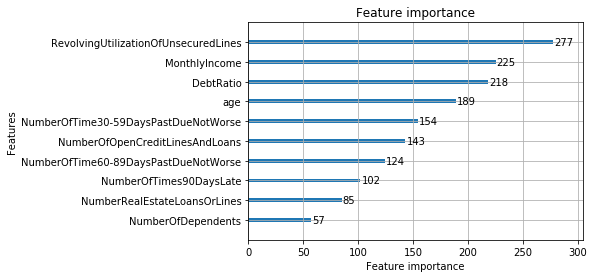

In [25]:
# retrain
train_lgb(train_resize, feat_X, feat_y, cat_feat=None, params=params, plot=True, seed=100, N=1000)

We've seen the `Precison and Recall` has gone better while `AUC` drops a little bit.

Although there is more we can do, but as time is limited, let's use the current model and make a submission.

## Submission

In [28]:
test = pd.read_csv("data/cs-test.csv")
test.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,NaN,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0
1,2,NaN,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0
2,3,NaN,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0
3,4,NaN,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0
4,5,NaN,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0


In [29]:
bst = lgb.Booster(model_file='model/lgb.txt')

y_pred = bst.predict(test[feat_X])

In [31]:
sub = pd.read_csv("data/sampleEntry.csv")
sub.head()

,Id,Probability
0,1,0.080807
1,2,0.040719
2,3,0.011968
3,4,0.067640
4,5,0.108264


In [32]:
sub["Probability"] = y_pred
sub.to_csv('data/sub1.csv', index=False)

## Questions Answer
---
1. __Tell us how you validate your model, which, and why you chose such evaluation technique(s)__.

I evaluated the model use train test split, basic technique for data training and evaluation. It splits the test set from training so that the evaluation result is independent from training process.

2. __What is AUC? Why do you think AUC was used as the evaluation metric for such a problem? What are other metrics that you think would also be suitable for this competition?__

AUC is `area under curve`, with `FPR` as x-axis and `TPR` as y-axis, it indicates how strong the model is to distinguish positive cases from negative ones.

This case is an unbalanced data set, where in this scenario we mostly care about the positive case. While accuracy score can be deceptive in there cases, as in extreme cases, if we predict everything as negative, we would get a good accuracy, but that is what we do not want. So there comes `AUC`, as one of the evaluation metric for unbalanced data, we evaluate how good the model is able to distinguish positive cases while commit few errors of predicting negative as positive.

Other metrics I've listed in the script above, for these cases, we normally use `precision, recall, f1`.

3. __What insight(s) do you have from your model? What is your preliminary analysis of the given dataset?__

The model I used here is `lightgbm`. I've always prefer boosting models for tabular data, as from most competition experiences in Kaggle, boosting model always exceeds others. Comparing the most common boosting models, `lightgbm vs. xgboost`, I even prefer `lightgbm`, as it is even faster from my most experience. It leverages a bining method to quickly find the split points and grow tree leave-wise so it can hand huge data sets.

Besides the above, `lightgbm` even samples data set based on its gradient that points with larger gradient are become more important for feature training. And bundle features to accelerate the training, and many more ...

My preliminary analysis is that data is biased and it's very basic (I am not sure what this question is asking about).

4. __Can you get into the top 100 of the private leaderboard, or even higher?__

Consider this is a 8-year ago competition, I think I can. There is a lot more to do here, grid-search for best parameters, cross-validation, better sampling techniques, ... . BTW, I believe you can ask me during interview.